## [Masked AutoEncoders](https://arxiv.org/pdf/2111.06377.pdf). 

Masked AutoEncoders is a simple algorithm to train a network in self-supervised way. The core idea is to randomly mask some of the tokens and learn these from the remaining un-masked tokens. There are several tricks used like deleting masked tokens to make the encoder lightweight and pre-train it in certain way. In this blog we will see what does MAE mean and how it is applied to ViT 

<img src="images/mae.png" width=400 height=400>

The core-concept of SimMIM and MAE is the same. The only change is that masked patches are replaced with a trainable mask token at the input itself for SimMIM. For MAE, this is efficiently added directly to the decoder. This according to the paper improves the training time by 3x. 

Lets load the required libraries. 

In [ ]:
import math
import numpy as np
import torch
import torch.nn as nn
import fastcore.all as fc
from PIL import Image
from functools import partial
from torchvision.transforms import RandomResizedCrop, RandomHorizontalFlip, Compose, ToTensor, ToPILImage

import matplotlib.pyplot as plt
plt.style.use("bmh")
%matplotlib inline

> Lets create an image of size 224x224 with a patch size of 16

In [ ]:
img_size = 224
patch_size = 32

## load and visualize an image

we load and use `coco val` data. For this blog purpose, u can pick up any image of your choice from the internet.

In [ ]:
imgs = fc.L(fc.Path("coco/val2017/").glob("*.jpg"))
imgs

(#5000) [Path('coco/val2017/000000182611.jpg'),Path('coco/val2017/000000335177.jpg'),Path('coco/val2017/000000278705.jpg'),Path('coco/val2017/000000463618.jpg'),Path('coco/val2017/000000568981.jpg'),Path('coco/val2017/000000092416.jpg'),Path('coco/val2017/000000173830.jpg'),Path('coco/val2017/000000476215.jpg'),Path('coco/val2017/000000479126.jpg'),Path('coco/val2017/000000570664.jpg')...]

> The following are the standard transforms mentioned in the paper.

In [ ]:
def transforms(img_size):
    return Compose([RandomResizedCrop(size=img_size, scale=[0.4, 1], ratio=[0.75, 1.33], interpolation=2), 
                    RandomHorizontalFlip(p=0.5), 
                    ToTensor()])

def load_img(img_loc, transforms):
    img = Image.open(img_loc)
    return transforms(img)

load_img = partial(load_img, transforms=transforms(img_size=img_size))

In [ ]:
img = load_img(imgs[1])
img.shape

torch.Size([3, 224, 224])

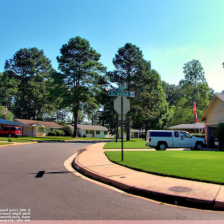

In [ ]:
ToPILImage()(img)

## Creating Image patches 

In [ ]:
imgp = img.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size).permute((0, 3, 4, 1, 2)).flatten(3).permute((3, 0, 1, 2))
imgp.shape

torch.Size([49, 3, 32, 32])

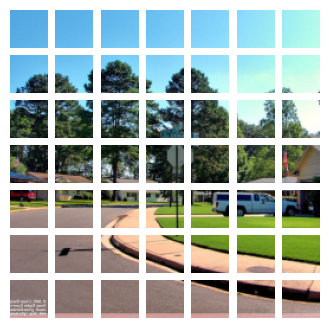

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4), nrows=7, ncols=7)
for n, i in enumerate(imgp):
    ax.flat[n].imshow(ToPILImage()(i))
    ax.flat[n].axis("off")
plt.show()

## Mask the tokens 

In [ ]:
tokens = imgp.shape[0]
mask_ratio = 0.75
mask_count = int(tokens* mask_ratio)
tokens, mask_count

(49, 36)

In [ ]:
mask_idx = torch.randperm(tokens)[:mask_count]
mask = torch.zeros(tokens).long()
mask[mask_idx] = 1
mask

tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        0])

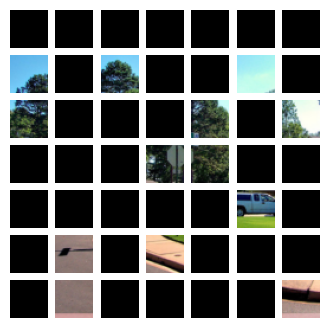

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4), nrows=7, ncols=7)
for n, i in enumerate(imgp):
    if mask[n] == 1:
        i = torch.zeros(3, 32, 32)
    ax.flat[n].imshow(ToPILImage()(i))
    ax.flat[n].axis("off")
plt.show()

> Creating a Embedding vector to each non-masked token.

In [ ]:
input_tokens = imgp[~mask.bool(), ...].flatten(1)
input_tokens.shape

torch.Size([13, 3072])

In [ ]:
imgp[~mask.bool(), ...].shape

torch.Size([13, 3, 32, 32])

## Encoder
In the encoder block, we patch the non-masked tokens, add positional encodings, append mask token and then pass them through transformer blocks to learn the representations of the image. 

<img src="images/mae_encoder.png" width=200 height=200>

> Patch the tokens.

In [ ]:
embed_dim = 768
pe = PatchEmbed(img_size=(32, 32), patch_size=(32,32), embed_dim=768, in_chans=3)
input_tokens = pe(imgp[~mask.bool(), ...]).squeeze(1)
input_tokens.shape

torch.Size([13, 768])

> Add positonal encodings 

In [ ]:
num_patches = (img_size//patch_size)**2
pos_embed = nn.Parameter(torch.zeros(num_patches, embed_dim), requires_grad=False)
print(pos_embed.shape)

torch.Size([49, 768])


In [ ]:
pos_embed[~mask.bool(), ...].shape

torch.Size([13, 768])

In [ ]:
pos_input_tokens = input_tokens+pos_embed[~mask.bool(), ...]
pos_input_tokens.shape

torch.Size([13, 768])

> add cls token

In [ ]:
cls_token = nn.Parameter(torch.zeros(1, embed_dim))
cls_token.shape

torch.Size([1, 768])

In [ ]:
tokens = torch.cat([cls_token, pos_input_tokens])
tokens.shape

torch.Size([14, 768])

> Lets pass the token through a few transformer blocks.

We have already discussed what happens inside a vision transformer blocks [here](). In general, attention matrix is calculated between each token.

In [ ]:
from timm.models.vision_transformer import Block

In [ ]:
block = Block(768, num_heads=12)
block

Block(
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attn): Attention(
    (qkv): Linear(in_features=768, out_features=2304, bias=False)
    (q_norm): Identity()
    (k_norm): Identity()
    (attn_drop): Dropout(p=0.0, inplace=False)
    (proj): Linear(in_features=768, out_features=768, bias=True)
    (proj_drop): Dropout(p=0.0, inplace=False)
  )
  (ls1): Identity()
  (drop_path1): Identity()
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): Mlp(
    (fc1): Linear(in_features=768, out_features=3072, bias=True)
    (act): GELU(approximate='none')
    (drop1): Dropout(p=0.0, inplace=False)
    (norm): Identity()
    (fc2): Linear(in_features=3072, out_features=768, bias=True)
    (drop2): Dropout(p=0.0, inplace=False)
  )
  (ls2): Identity()
  (drop_path2): Identity()
)

In [ ]:
encodings = block(tokens.unsqueeze(0)).squeeze(0)
encodings.shape

torch.Size([14, 768])

## Decoder 
In the decoder, we will learn from the tokens from encoder+mask tokens.

<img src="images/mae_decoder.png" width=200 height=200>


> `Decoder_embed -> Add mask_tokens -> Add positional embeddings -> Pass through Decoder blocks -> Decoder norm -> Decoder prediction layer`

The mask_tokens which are added to the encoder in `Masked Image Modelling` are added directly to decoder here. Positional embeddings are once again added. Then the decoder tokens are passed through a few decoder blocks before passing to the prediction layer.

In [ ]:
mask.shape, encodings.shape

(torch.Size([49]), torch.Size([14, 768]))

> Lets create a decoder embed

In [ ]:
decoder_embed_dim = 512
decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)
decoder_embed

Linear(in_features=768, out_features=512, bias=True)

In [ ]:
decoder_tokens = decoder_embed(encodings)
decoder_tokens.shape

torch.Size([14, 512])

> Add mask token

In [ ]:
mask_token = nn.Parameter(torch.zeros(1, decoder_embed_dim))
torch.nn.init.normal_(mask_token, std=.02)
mask_token.shape

torch.Size([1, 512])

In [ ]:
tokens = torch.zeros((num_patches, decoder_embed_dim))
tokens[~mask.bool()] = decoder_tokens[1:, :]
tokens[mask.bool()] = torch.cat([mask_token]*(num_patches-(~mask.bool()).sum()))
tokens.shape

torch.Size([49, 512])

> Add decoder positional emebdding 

In [ ]:
decoder_pos_embed = nn.Parameter(torch.zeros(num_patches, decoder_embed_dim))
print(decoder_pos_embed.shape)

torch.Size([49, 512])


In [ ]:
tokens = tokens+decoder_pos_embed
tokens.shape

torch.Size([49, 512])

> Add the mask token back 

In [ ]:
tokens = torch.cat([decoder_tokens[:1, :], tokens])
tokens.shape

torch.Size([50, 512])

In [ ]:
decoder_num_heads = 8
decoder_block = Block(decoder_embed_dim, decoder_num_heads, 4, qkv_bias=True, norm_layer=nn.LayerNorm)
decoder_block

Block(
  (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (attn): Attention(
    (qkv): Linear(in_features=512, out_features=1536, bias=True)
    (q_norm): Identity()
    (k_norm): Identity()
    (attn_drop): Dropout(p=0.0, inplace=False)
    (proj): Linear(in_features=512, out_features=512, bias=True)
    (proj_drop): Dropout(p=0.0, inplace=False)
  )
  (ls1): Identity()
  (drop_path1): Identity()
  (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (mlp): Mlp(
    (fc1): Linear(in_features=512, out_features=2048, bias=True)
    (act): GELU(approximate='none')
    (drop1): Dropout(p=0.0, inplace=False)
    (norm): Identity()
    (fc2): Linear(in_features=2048, out_features=512, bias=True)
    (drop2): Dropout(p=0.0, inplace=False)
  )
  (ls2): Identity()
  (drop_path2): Identity()
)

In [ ]:
out_tokens = decoder_block(tokens.unsqueeze(0)).squeeze(0)
out_tokens.shape

torch.Size([50, 512])

> Add norm and prediction layer 

In [ ]:
decoder_norm = nn.LayerNorm(decoder_embed_dim)
decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * 3, bias=True) # decoder to patch
decoder_pred

Linear(in_features=512, out_features=3072, bias=True)

In [ ]:
out = decoder_norm(out_tokens.unsqueeze(0)).squeeze(0)
# predictor projection
out = decoder_pred(out)
out.shape

torch.Size([50, 3072])

In [ ]:
final_img_predictions = out[1:, :]#remove mask tokens
final_img_predictions.shape

torch.Size([49, 3072])

## Calculate the loss 

In [ ]:
inputs = imgp.flatten(1)
inputs.shape, final_img_predictions.shape, mask.shape

(torch.Size([49, 3072]), torch.Size([49, 3072]), torch.Size([49]))

> normalize the inputs

In [ ]:
mean = inputs.mean(dim=-1, keepdim=True)
var = inputs.var(dim=-1, keepdim=True)
inputs = (inputs - mean) / (var + 1.e-6)**.5
inputs.shape

torch.Size([49, 3072])

> lets calculate loss at token level. we use L2 loss hear

$$
loss = \frac{\sum_{n=0}^{tokens}(input-pred)^2}{tokens}
$$

In [ ]:
token_level_loss = ((final_img_predictions - inputs)**2).mean(dim=-1)
token_level_loss

tensor([1.2956, 1.2957, 1.2958, 1.2953, 1.2959, 1.2986, 1.3030, 1.3511, 1.2920,
        1.3418, 1.3070, 1.3064, 1.3655, 1.3243, 1.3636, 1.3203, 1.3219, 1.3430,
        1.3018, 1.3150, 1.3658, 1.3392, 1.3049, 1.3325, 1.3049, 1.3594, 1.3246,
        1.3365, 1.3253, 1.3419, 1.3339, 1.3432, 1.3398, 1.3425, 1.3280, 1.3548,
        1.3326, 1.3543, 1.3605, 1.3624, 1.3378, 1.3361, 1.3377, 1.3140, 1.3287,
        1.3284, 1.3201, 1.3530, 1.3226], grad_fn=<MeanBackward1>)

In [ ]:
loss = (token_level_loss * mask).sum() / mask.sum()
loss

tensor(1.3242, grad_fn=<DivBackward0>)

## END 
- The authors in this paper have tried several different decoder blocks and found that having one transformer based decoder block is suffient in the finetuning stage. 
- Also several mask_ratios were tried and found that 75% works well on all down stream tasks. 
- During the fine-tuning stage, since there are no mask tokens, All tokens were passed through the encoder.
- How do we implement this for an architecture like `ViTDet`. This is not possible as randomly removing the tokens breaks the 2D grid. We will cover techinques to make this feasible in the next blog. 
- On imagenet using ViT-B has 83.6%, ViT-L has 85.9%, ViT-H has 86.9% accuracy. On ViT-H with img_size as 448, it reached an accuracy of 87.8%. 